build a encoder-decoder model order input from least to greastest.  first step just return the indices of fixed lenght input, second step variable lenght input, embedding layer and pointer network. 

Note that sequences are of fixed lenght

In [1]:
import numpy as np
import tensorflow as tf
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:

# Global config variables
num_steps = 4 
batch_size = 16
state_size = 12
learning_rate = 0.1


In [3]:

def gen_data(time_steps=4, batch_size=16, num_batches=4000):
    X = np.random.rand(num_batches * batch_size, time_steps)
    Y = np.asarray([np.argsort(e) for e in X])
    for i in range(num_batches):
        _x = X[i * batch_size:(i + 1) * batch_size]
        _y = Y[i * batch_size:(i + 1) * batch_size]
        yield _x, _y


In [4]:
"""
Placeholders
"""

x = tf.placeholder(tf.float32, [batch_size, num_steps], name='input_placeholder')
y = tf.placeholder(tf.int32, [batch_size, num_steps], name='labels_placeholder')
init_state = tf.zeros([batch_size, state_size])

"""
RNN Inputs
"""

# Turn our x placeholder into a list of one-hot tensors:
# rnn_inputs is a list of num_steps tensors with shape [batch_size, num_classes]
rnn_inputs = tf.expand_dims(x, 2)
rnn_inputs = tf.unstack(rnn_inputs, axis=1)


In [5]:

with tf.variable_scope('rnn_cell'):
    W = tf.get_variable('W', [1 + state_size, state_size])
    b = tf.get_variable('b', [state_size], initializer=tf.constant_initializer(0.0))

def rnn_cell(rnn_input, state):
     print rnn_input
     print state
     return tf.tanh(tf.matmul(tf.concat([rnn_input, state], 1), W) + b)

In [6]:
state = init_state
rnn_outputs = []
for rnn_input in rnn_inputs:
    state = rnn_cell(rnn_input, state)
    rnn_outputs.append(state)
final_state = rnn_outputs[-1]

Tensor("unstack:0", shape=(16, 1), dtype=float32)
Tensor("zeros:0", shape=(16, 12), dtype=float32)
Tensor("unstack:1", shape=(16, 1), dtype=float32)
Tensor("Tanh:0", shape=(16, 12), dtype=float32)
Tensor("unstack:2", shape=(16, 1), dtype=float32)
Tensor("Tanh_1:0", shape=(16, 12), dtype=float32)
Tensor("unstack:3", shape=(16, 1), dtype=float32)
Tensor("Tanh_2:0", shape=(16, 12), dtype=float32)


In [7]:
#decoder inputs

# rnn_inputs is a list of num_steps tensors with shape [batch_size, num_classes]
decoder_inputs = tf.expand_dims(y, 2)
decoder_inputs = tf.unstack(decoder_inputs, axis=1)

#we want to insert starter symbols at beginning of list and drop last element of list
start = tf.ones([batch_size, 1])
start = tf.scalar_mul(-1, start)
decoder_inputs.insert(0, start)
del decoder_inputs[-1]
decoder_inputs

[<tf.Tensor 'mul:0' shape=(16, 1) dtype=float32>,
 <tf.Tensor 'unstack_1:0' shape=(16, 1) dtype=int32>,
 <tf.Tensor 'unstack_1:1' shape=(16, 1) dtype=int32>,
 <tf.Tensor 'unstack_1:2' shape=(16, 1) dtype=int32>]

In [8]:
#decoder cell
with tf.variable_scope('decoder_cell'):
    Wd = tf.get_variable('W', [1 + state_size, state_size])
    bd = tf.get_variable('b', [state_size], initializer=tf.constant_initializer(0.0))



In [9]:
def rnn_cell_d(decoder_input, state):
     return tf.tanh(tf.matmul(tf.concat([decoder_input, state], 1), Wd) + bd)
    
state = final_state
decoder_outputs = []
for decoder_input in decoder_inputs:
    state = rnn_cell_d(rnn_input, state)
    decoder_outputs.append(state)


In [10]:
num_classes = num_steps
with tf.variable_scope('softmax'):
    W = tf.get_variable('W', [state_size, num_classes])
    b = tf.get_variable('b', [num_classes], initializer=tf.constant_initializer(0.0))
logits = [tf.matmul(decoder_output, W) + b for decoder_output in decoder_outputs]
predictions = [tf.nn.softmax(logit) for logit in logits]



In [11]:
y_as_list = tf.unstack(y, num=num_steps, axis=1)

#losses and train_step
losses = [tf.nn.sparse_softmax_cross_entropy_with_logits(labels=label, logits=logit) for \
          logit, label in zip(logits, y_as_list)]
total_loss = tf.reduce_mean(losses)
train_step = tf.train.AdagradOptimizer(learning_rate).minimize(total_loss)

In [12]:

def train_network(num_epochs, num_steps, state_size, verbose=True):
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        training_losses = []
        for i in range(num_epochs):
            training_loss = 0

            if verbose:
                print("\nEPOCH", i)
            d = gen_data(time_steps=4, batch_size=16, num_batches=4000)
            for j in range(4000):
                X,Y = d.next()
                training_state = np.zeros((batch_size, state_size))
                tr_losses, training_loss_, training_state, _, preds_ = \
                    sess.run([losses,
                              total_loss,
                              final_state,
                              train_step,
                              predictions],
                                  feed_dict={x:X, y:Y, init_state:training_state})
                training_loss += training_loss_

                if j % 40 == 0 and j > 0:
                    if verbose:
                        print("Average loss at step", j,
                              "for last 250 steps:", training_loss / 100)
                    training_losses.append(training_loss / 100)
                    training_loss = 0

    return training_losses



('\nEPOCH', 0)
('Average loss at step', 40, 'for last 250 steps:', 0.5325344812870025)
('Average loss at step', 80, 'for last 250 steps:', 0.4382232815027237)
('Average loss at step', 120, 'for last 250 steps:', 0.41487195730209353)
('Average loss at step', 160, 'for last 250 steps:', 0.37303140938282014)
('Average loss at step', 200, 'for last 250 steps:', 0.32651673913002016)
('Average loss at step', 240, 'for last 250 steps:', 0.2996251499652863)
('Average loss at step', 280, 'for last 250 steps:', 0.2713623225688934)
('Average loss at step', 320, 'for last 250 steps:', 0.25633897721767424)
('Average loss at step', 360, 'for last 250 steps:', 0.2327279818058014)
('Average loss at step', 400, 'for last 250 steps:', 0.22611956983804704)
('Average loss at step', 440, 'for last 250 steps:', 0.21668175041675566)
('Average loss at step', 480, 'for last 250 steps:', 0.20703913301229476)
('Average loss at step', 520, 'for last 250 steps:', 0.20386673718690873)
('Average loss at step', 560, 

('Average loss at step', 480, 'for last 250 steps:', 0.08050698034465313)
('Average loss at step', 520, 'for last 250 steps:', 0.07866134718060494)
('Average loss at step', 560, 'for last 250 steps:', 0.08517490565776825)
('Average loss at step', 600, 'for last 250 steps:', 0.07722952298820018)
('Average loss at step', 640, 'for last 250 steps:', 0.08367189131677151)
('Average loss at step', 680, 'for last 250 steps:', 0.08017007529735565)
('Average loss at step', 720, 'for last 250 steps:', 0.0846890876442194)
('Average loss at step', 760, 'for last 250 steps:', 0.07849931813776494)
('Average loss at step', 800, 'for last 250 steps:', 0.08517688304185868)
('Average loss at step', 840, 'for last 250 steps:', 0.07871231235563755)
('Average loss at step', 880, 'for last 250 steps:', 0.08507458575069904)
('Average loss at step', 920, 'for last 250 steps:', 0.08101630046963691)
('Average loss at step', 960, 'for last 250 steps:', 0.07902063928544521)
('Average loss at step', 1000, 'for las

('Average loss at step', 1000, 'for last 250 steps:', 0.06770276326686143)
('Average loss at step', 1040, 'for last 250 steps:', 0.06513030283153057)
('Average loss at step', 1080, 'for last 250 steps:', 0.06119546055793762)
('Average loss at step', 1120, 'for last 250 steps:', 0.07463228292763233)
('Average loss at step', 1160, 'for last 250 steps:', 0.067016611546278)
('Average loss at step', 1200, 'for last 250 steps:', 0.06894581973552703)
('Average loss at step', 1240, 'for last 250 steps:', 0.0690011727809906)
('Average loss at step', 1280, 'for last 250 steps:', 0.07562428414821624)
('Average loss at step', 1320, 'for last 250 steps:', 0.07278162993490696)
('Average loss at step', 1360, 'for last 250 steps:', 0.06869991667568684)
('Average loss at step', 1400, 'for last 250 steps:', 0.07516860913485289)
('Average loss at step', 1440, 'for last 250 steps:', 0.07095152497291565)
('Average loss at step', 1480, 'for last 250 steps:', 0.06504515014588833)
('Average loss at step', 152

('Average loss at step', 1480, 'for last 250 steps:', 0.06156477205455303)
('Average loss at step', 1520, 'for last 250 steps:', 0.059479803144931793)
('Average loss at step', 1560, 'for last 250 steps:', 0.07220002844929695)
('Average loss at step', 1600, 'for last 250 steps:', 0.06105424460023642)
('Average loss at step', 1640, 'for last 250 steps:', 0.059496281892061235)
('Average loss at step', 1680, 'for last 250 steps:', 0.07077763963490724)
('Average loss at step', 1720, 'for last 250 steps:', 0.05448203768581152)
('Average loss at step', 1760, 'for last 250 steps:', 0.05989430163055658)
('Average loss at step', 1800, 'for last 250 steps:', 0.06134968087077141)
('Average loss at step', 1840, 'for last 250 steps:', 0.06563509624451398)
('Average loss at step', 1880, 'for last 250 steps:', 0.06048457957804203)
('Average loss at step', 1920, 'for last 250 steps:', 0.06363281890749932)
('Average loss at step', 1960, 'for last 250 steps:', 0.06516878068447113)
('Average loss at step'

('Average loss at step', 1960, 'for last 250 steps:', 0.05871973197907209)
('Average loss at step', 2000, 'for last 250 steps:', 0.06738993890583515)
('Average loss at step', 2040, 'for last 250 steps:', 0.06304577499628067)
('Average loss at step', 2080, 'for last 250 steps:', 0.05571371525526047)
('Average loss at step', 2120, 'for last 250 steps:', 0.062369270399212834)
('Average loss at step', 2160, 'for last 250 steps:', 0.061530077159404756)
('Average loss at step', 2200, 'for last 250 steps:', 0.052694691345095634)
('Average loss at step', 2240, 'for last 250 steps:', 0.06020082019269466)
('Average loss at step', 2280, 'for last 250 steps:', 0.0578883333131671)
('Average loss at step', 2320, 'for last 250 steps:', 0.05733067374676466)
('Average loss at step', 2360, 'for last 250 steps:', 0.06081079185009003)
('Average loss at step', 2400, 'for last 250 steps:', 0.060591468289494514)
('Average loss at step', 2440, 'for last 250 steps:', 0.06213688313961029)
('Average loss at step

('Average loss at step', 2440, 'for last 250 steps:', 0.05457514949142933)
('Average loss at step', 2480, 'for last 250 steps:', 0.05513036657124758)
('Average loss at step', 2520, 'for last 250 steps:', 0.049313885569572447)
('Average loss at step', 2560, 'for last 250 steps:', 0.05448789667338133)
('Average loss at step', 2600, 'for last 250 steps:', 0.051489553041756154)
('Average loss at step', 2640, 'for last 250 steps:', 0.05532611943781376)
('Average loss at step', 2680, 'for last 250 steps:', 0.0629106929153204)
('Average loss at step', 2720, 'for last 250 steps:', 0.05197285626083612)
('Average loss at step', 2760, 'for last 250 steps:', 0.06005380600690842)
('Average loss at step', 2800, 'for last 250 steps:', 0.056512660533189776)
('Average loss at step', 2840, 'for last 250 steps:', 0.051266723535954954)
('Average loss at step', 2880, 'for last 250 steps:', 0.051907678842544554)
('Average loss at step', 2920, 'for last 250 steps:', 0.06293267462402583)
('Average loss at ste

('Average loss at step', 2920, 'for last 250 steps:', 0.06286906540393829)
('Average loss at step', 2960, 'for last 250 steps:', 0.05737228266894817)
('Average loss at step', 3000, 'for last 250 steps:', 0.05563269153237343)
('Average loss at step', 3040, 'for last 250 steps:', 0.04922216944396496)
('Average loss at step', 3080, 'for last 250 steps:', 0.06017128325998783)
('Average loss at step', 3120, 'for last 250 steps:', 0.05224546771496534)
('Average loss at step', 3160, 'for last 250 steps:', 0.05324473053216934)
('Average loss at step', 3200, 'for last 250 steps:', 0.060412814505398274)
('Average loss at step', 3240, 'for last 250 steps:', 0.05171222269535065)
('Average loss at step', 3280, 'for last 250 steps:', 0.05901225283741951)
('Average loss at step', 3320, 'for last 250 steps:', 0.054782560765743255)
('Average loss at step', 3360, 'for last 250 steps:', 0.0551578626409173)
('Average loss at step', 3400, 'for last 250 steps:', 0.05517797470092774)
('Average loss at step',

('Average loss at step', 3400, 'for last 250 steps:', 0.05275844104588032)
('Average loss at step', 3440, 'for last 250 steps:', 0.05364502757787704)
('Average loss at step', 3480, 'for last 250 steps:', 0.054411569330841306)
('Average loss at step', 3520, 'for last 250 steps:', 0.05529086343944073)
('Average loss at step', 3560, 'for last 250 steps:', 0.054541450515389445)
('Average loss at step', 3600, 'for last 250 steps:', 0.0472276826761663)
('Average loss at step', 3640, 'for last 250 steps:', 0.054417113028466704)
('Average loss at step', 3680, 'for last 250 steps:', 0.05474153447896242)
('Average loss at step', 3720, 'for last 250 steps:', 0.05249707572162152)
('Average loss at step', 3760, 'for last 250 steps:', 0.04553873714059591)
('Average loss at step', 3800, 'for last 250 steps:', 0.05453128382563591)
('Average loss at step', 3840, 'for last 250 steps:', 0.05151906261220574)
('Average loss at step', 3880, 'for last 250 steps:', 0.053006858378648755)
('Average loss at step

('Average loss at step', 3880, 'for last 250 steps:', 0.04902859631925821)
('Average loss at step', 3920, 'for last 250 steps:', 0.04798102505505085)
('Average loss at step', 3960, 'for last 250 steps:', 0.050633953660726545)
('\nEPOCH', 9)
('Average loss at step', 40, 'for last 250 steps:', 0.0535687118396163)
('Average loss at step', 80, 'for last 250 steps:', 0.055827782824635505)
('Average loss at step', 120, 'for last 250 steps:', 0.0486322333291173)
('Average loss at step', 160, 'for last 250 steps:', 0.04926859512925148)
('Average loss at step', 200, 'for last 250 steps:', 0.050444849915802475)
('Average loss at step', 240, 'for last 250 steps:', 0.05002686398103833)
('Average loss at step', 280, 'for last 250 steps:', 0.04979248646646738)
('Average loss at step', 320, 'for last 250 steps:', 0.05311309300363064)
('Average loss at step', 360, 'for last 250 steps:', 0.05069215739145875)
('Average loss at step', 400, 'for last 250 steps:', 0.04787358390167355)
('Average loss at ste

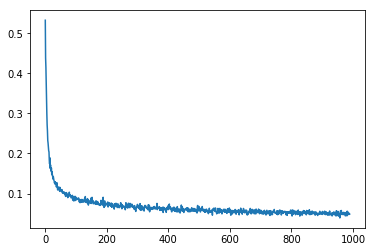

In [13]:
training_losses = train_network(10,num_steps, state_size)
plt.plot(training_losses)